# Analyzing Franz Kafka's _The Metamorphosis_ with NLP

* Kafka's _Metamorphosis_ is commonly interpreted by humans as giving insights into the meaning of personal identity
* The conclusions that we can draw from texts are limited by our uniquely human preconceptions and rhetorical weaknesses
* Guiding question: What happens when computers read philosophy? That is, if we apply machine learning and linguistic approaches from natural language processing (NLP) to analyzing _The Metamorphosis_, how will the results support or contrast with our human reading?
* Read on to see what computers think about Kafka...

First, import the libraries that will be helpful later on.

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import random
import numpy as np
import regex as re
import pandas as pd
from matplotlib import pyplot as plt

The text is sourced from Project Gutenberg (David Wyllie
 translation): http://www.gutenberg.org/files/5200/5200-h/5200-h.htm.

In [4]:
file = open("5200-h.txt", "r")
content = file.read()

Clean messy string into individual word tokens (includes punctuation and contraction fragments) with some regex magic.

In [5]:
words = re.findall(r'\w+', content)

In [6]:
random.sample(words, 15)

['more',
 'the',
 'behind',
 'picture',
 'was',
 'if',
 'keep',
 'hair',
 'my',
 'like',
 'as',
 'lain',
 'his',
 'to',
 'they']

Lots of words!

In [7]:
len(words)

22383

## Word frequencies

Count how many times each word occurs. Words are converted to lowercase to simplify things.

In [8]:
def get_word_freqs(words):
    freqs = {}
    for word in words:
        lower = word.lower()
        if lower in freqs:
            freqs[lower] += 1
        else:
            freqs[lower] = 1
    return freqs

In [9]:
word_freqs_dict = get_word_freqs(words)

Convert the dictionary of frequencies to a Pandas Series (nicer for lots of data). Note that there are far fewer unique than total words.

In [10]:
word_freqs = pd.Series(word_freqs_dict)
len(word_freqs)

2578

The 30 most frequently occurring words. By far the most common word is "the", which isn't surprising given its grammatical importance. In fact, most of these words aren't specific to _The Metamorphosis_. Interestingly, "room" appears more often even than generally common words "be" and "could", which suggests its significance in the story.

In [11]:
word_freqs.nlargest(30)

the       1148
to         753
and        642
he         590
his        550
of         429
was        409
it         370
had        352
in         348
that       345
gregor     298
a          285
as         242
she        200
with       199
s          194
him        188
her        187
would      187
not        176
but        171
at         169
for        166
they       160
on         152
all        135
room       131
be         119
could      119
dtype: int64

Since many of these words aren't very interesting, let's forget about them for now. These words are called <a href="https://en.wikipedia.org/wiki/Stop_words" target="_blank">stop words</a>, and the NLP library nltk conveniently includes a list of them so we can exclude them.

Some example stop words. Some may be word fragments due to how nltk parses words.

In [12]:
stop_words = set(stopwords.words('english'))
random.sample(stop_words, 10)

['my',
 'as',
 'from',
 'down',
 'himself',
 "needn't",
 'both',
 "didn't",
 'before',
 'than']

Yay, that annoying "the" will be gone!

In [13]:
'the' in stop_words

True

Exclude the stop words to create a new series with only the salient words. Now the most common words are actually meaningful! We see the main character names at the top: Gregor and his father, sister, and mother. "Grete" doesn't appear on the list at all, reflecting Kafka's tendency to describe her in relation to Gregor (i.e. "his sister") rather than as her own character. That "room" appears at the top along with the important people suggests that it could be considered a character in itself: It plays an essential role in Gregor's development as he lives out his bug life, more so than any of his family members.

In [14]:
to_drop = [w for w in word_freqs.index if w in stop_words]
word_freqs_salient = word_freqs.drop(to_drop)
word_freqs_salient.nlargest(30)

gregor     298
would      187
room       131
could      119
father     102
sister     101
mother      89
door        87
back        82
even        80
one         72
way         62
time        59
said        51
little      49
first       44
get         44
still       44
go          40
made        40
see         39
without     39
head        38
like        38
much        38
chief       37
clerk       37
open        35
samsa       34
away        32
dtype: int64

## Word frequencies over time

Now that we've seen the patterns in word usage over the entire novella, let's see how they vary over time.

First get the positions of a given word throughout the text.

In [15]:
def get_word_indices(word):
    return [i for i,x in enumerate(words) if x == word]

For example, "picture" appears at these 6 positions. Five of these are clustered together in the section where Grete and the mother attempt to remove a picture from Gregor's rooom.

In [19]:
get_word_indices('picture')

[146, 13175, 13203, 13222, 13388, 13512]

Below is the frequency of "Gregor" over time. It tapers off at the end, after Gregor dies and the story turns to focus on his family. There's an interesting oscillating pattern, where "Gregor" alternately becomes frequent and infrequent.

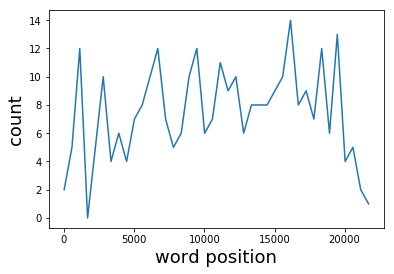

In [42]:
gregor_indices = get_word_indices('Gregor')
n, bins, _ = plt.hist(gregor_indices, bins=40)
plt.clf()
plt.plot(bins[:-1], n)
plt.xlabel('word position', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.show()

Let's see how this compares to the mentions of Gregor's family members.

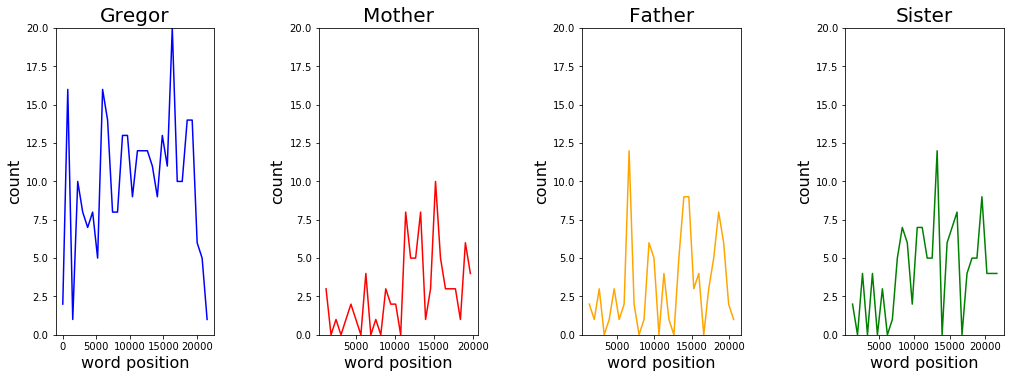

In [86]:
gregor_indices = get_word_indices('Gregor')
mother_indices = get_word_indices('mother')
father_indices = get_word_indices('father')
sister_indices = get_word_indices('sister') + get_word_indices('Grete')

n_gregor, bins_gregor, _ = plt.hist(gregor_indices, bins=30)
n_mother, bins_mother, _ = plt.hist(mother_indices, bins=30)
n_father, bins_father, _ = plt.hist(father_indices, bins=30)
n_sister, bins_sister, _ = plt.hist(sister_indices, bins=30)

plt.clf()

fig, ax = plt.subplots(nrows=1, ncols=4)

fig.tight_layout()
fig.set_figheight(5)
fig.set_figwidth(15)

ax[0].plot(bins_gregor[:-1], n_gregor, label="Gregor", color='blue');
ax[1].plot(bins_mother[:-1], n_mother, label='Mother', color='red');
ax[2].plot(bins_father[:-1], n_father, label='Father', color='orange');
ax[3].plot(bins_sister[:-1], n_sister, label='Sister', color='green');

chars = ['Gregor', 'Mother', 'Father', 'Sister']

for i in range(len(ax)):
    ax_i = ax[i]
    ax[i].set_title(chars[i], fontsize=20)
    ax[i].set_ylim([0, 20])
    ax[i].set_ylabel('count', fontsize=16)
    ax[i].set_xlabel('word position', fontsize=16)

plt.show()